In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [23]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [25]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("data"))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [26]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [27]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
test_size=0.20, stratify=labels, random_state=42)


aug = ImageDataGenerator(
      rotation_range=20,
      zoom_range=0.15,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.15,
      horizontal_flip=True,
      fill_mode="nearest")

In [28]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
     input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
     layer.trainable = False

In [29]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 43s 1s/step - loss: 0.4825 - accuracy: 0.7734 - val_loss: 0.1406 - val_accuracy: 0.9674
Epoch 2/20
34/34 [==============================] - 43s 1s/step - loss: 0.1323 - accuracy: 0.9616 - val_loss: 0.0615 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 43s 1s/step - loss: 0.0815 - accuracy: 0.9803 - val_loss: 0.0408 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 43s 1s/step - loss: 0.0554 - accuracy: 0.9831 - val_loss: 0.0302 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 43s 1s/step - loss: 0.0539 - accuracy: 0.9841 - val_loss: 0.0239 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 42s 1s/step - loss: 0.0352 - accuracy: 0.9897 - val_loss: 0.0202 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 41s 1s/step - loss: 0.0308 - accuracy: 0.9934 - val_loss: 

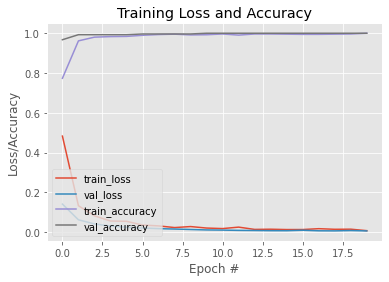

In [36]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [37]:
print("[INFO] evaluaing the model...")
y_pred= model.predict(testX)

y_pred= np.argmax(y_pred,axis=1)
print(classification_report(testY.argmax(axis=1),y_pred,target_names=lb.classes_))

[INFO] evaluaing the model...
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [38]:
print("[INFO] saving the model...")
model.save("mask_detector.h5")

[INFO] saving the model...
